Run this script by pressing the "play" button or by clicking on the cell and pressing control+enter (command+enter on a Mac). This extracts COVID data from four seperate databases and merges them together to create a single dataframe. 

In [2]:
"""Pulls Covid data from four separate US Gov databases and merges them
together to create a single data source"""
from datetime import datetime
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates 

HD_TEST = 'https://beta.healthdata.gov/api/views/j8mb-icvb/rows.csv'
HD_HOSP = 'https://beta.healthdata.gov/api/views/g62h-syeh/rows.csv'
CDC_CASES= 'https://data.cdc.gov/api/views/9mfq-cb36/rows.csv'

STATE_ABBV = 'https://worldpopulationreview.com/states/state-abbreviations'
CENSUS_AGE = 'https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/asrh/sc-est2019-agesex-civ.csv'
CDC_VACC = 'https://data.cdc.gov/api/views/8xkx-amqh/rows.csv'

def get_cases():
    """Gathers case/death data"""
    cases = pd.read_csv(CDC_CASES)
    cases['date'] = [datetime.strptime(x, '%m/%d/%Y') for x in cases['submission_date']]
    cases.drop('submission_date', axis=1, inplace=True)
    cases['cfr%'] = cases['new_death']/cases['new_case']*100
    return cases

def get_hosp():
    """Gathers hospitalization data"""
    hosp = pd.read_csv(HD_HOSP).sort_values('date', ascending=False)
    hosp['date'] = [datetime.strptime(x, '%Y/%m/%d') for x in hosp['date']]
    return hosp

def get_test():
    """Gathers testing data"""
    test = pd.read_csv(HD_TEST).sort_values(by='date',ascending=False)
    test['date'] = [datetime.strptime(x, '%Y/%m/%d') for x in test['date']]
    test = test.pivot(index=['date', 'state'], columns = 'overall_outcome', values = [
      'new_results_reported', 'total_results_reported'])
    test.reset_index(inplace=True)
    test.columns = [col[0] for col in test.columns[0:2]] + [
                                          '_'.join(col) for col in test.columns[2:]]
    test['daily_total_tests'] = test[test.columns[2:5]].sum(axis=1)
    test['daily_test_positivity_rate%'] = test[test.columns[4]]/test['daily_total_tests']*100
    return test

def get_state_pop():
    """Creates a table of US state populations"""
    state_abbv = pd.read_html(STATE_ABBV)[0]
    census_by_age = pd.read_csv(CENSUS_AGE).rename(columns={'NAME':'State'})
    census_by_age_all = census_by_age.loc[census_by_age['SEX']==0]
    state_pop = census_by_age_all.merge(state_abbv, on='State')
    state_pop.rename(columns={'Code':'state'}, inplace=True)
    return state_pop

def get_pop_cat():
    """Calculates the US state populations for persons 12+, 18+, and 65+
    in age"""
    state_pop = get_state_pop()
    ages = [12, 18, 65, 999]
    cat_list = []

    for val in ages:
        cat_list.append(state_pop.loc[(state_pop['AGE']>=
            val)&(state_pop['AGE']<val+100)].groupby('state').sum().reset_index()[
              ['state', 'POPEST2019_CIV']].rename(columns = {
                'POPEST2019_CIV': str(val) + 'PlusPop'}))
    pop_cat = reduce(lambda  left,right: pd.merge(left,right,on=['state'],
                                                how='outer'), cat_list)
    pop_cat.rename(columns={'999PlusPop':'totalPop'}, inplace = True)
    return pop_cat

def get_vacc():
    """gathers vaccine data and merges it with the US State population
    data by age group"""
    vacc = pd.read_csv(CDC_VACC).rename(columns={'Recip_State':'state'})
    vacc['date'] = [datetime.strptime(x, '%m/%d/%Y') for x in vacc['Date']]
    vacc_state_totals = vacc.groupby(['date','state'])[['Series_Complete_Yes',
                          'Series_Complete_12Plus', 'Series_Complete_18Plus',
                          'Series_Complete_65Plus', 'Administered_Dose1_Recip',
            'Administered_Dose1_Recip_12Plus', 'Administered_Dose1_Recip_18Plus',
            'Administered_Dose1_Recip_65Plus']].sum().reset_index()
    vacc_state_totals_abbv = vacc_state_totals.merge(get_pop_cat(), on='state')
    return vacc_state_totals_abbv

def get_vacc_pop_pct():
    """Caculates the percentage of each age group that is either
    partially or fully vaccinated and adds it to the vaccination data."""
    vacc_data = get_vacc()
    values = ['Series_Complete_12Plus',
              'Series_Complete_18Plus', 'Series_Complete_65Plus',
             'Administered_Dose1_Recip_12Plus', 'Administered_Dose1_Recip_18Plus',
              'Administered_Dose1_Recip_65Plus']
    for val in values:
        vacc_data.insert(len(vacc_data.columns), f'{val}_Pop_Pct',
            vacc_data[val]/vacc_data[f'{val.rsplit("_", maxsplit=1)[-1][0:2]}PlusPop']*100)
    vacc_data['Administered_Dose1_Pop_Pct'] = vacc_data[
        'Administered_Dose1_Recip']/vacc_data['totalPop']*100
    vacc_data['Series_Complete_Pop_Pct'] = vacc_data[
        'Series_Complete_Yes']/vacc_data['totalPop']*100
    return vacc_data

def get_all_data():
    """Combines all COVID data into a single source"""
    all_data = reduce(lambda  left,right: pd.merge(left,right,
                                        on=['state', 'date'], how='outer'), [
                                          get_cases(), get_hosp(), get_test(), get_vacc_pop_pct()])
    all_data.sort_values('date', ascending = False, inplace=True)
    all_data.reset_index(drop=True, inplace=True)
    columns_order = list(all_data.columns)
    columns_order.insert(0, 'date')
    columns_order.pop(15)
    all_data = all_data[columns_order]
    return all_data

usa_covid_data = get_all_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: DtypeWarning: Columns (23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.


All of the data is now stored as a single dataframe named "usa_covid_data". 
Notes: 
1.) Hospitalization and vaccination data is often reported before testing and case/death data, which is why case and testing data is blank for recent dates. 
2.) Some states do not track certain variables. For instance, Texas does not have vaccination data in the vaccination database.

In [3]:
usa_covid_data

,date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,cfr%,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_50-59_coverage,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_60-69_coverage,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_70-79_coverage,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_80+_coverage,previous_day_admission_adult_covid_suspected_unknown,previous_day_admission_adult_covid_suspected_unknown_coverage,deaths_covid,deaths_covid_coverage,new_results_reported_Inconclusive,new_results_reported_Negative,new_results_reported_Positive,total_results_reported_Inconclusive,total_results_reported_Negative,total_results_reported_Positive,daily_total_tests,daily_test_positivity_rate%,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_18Plus,Series_Complete_65Plus,Administered_Dose1_Recip,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,12PlusPop,18PlusPop,65PlusPop,totalPop,Series_Complete_12Plus_Pop_Pct,Series_Complete_18Plus_Pop_Pct,Series_Complete_65Plus_Pop_Pct,Administered_Dose1_Recip_12Plus_Pop_Pct,Administered_Dose1_Recip_18Plus_Pop_Pct,Administered_Dose1_Recip_65Plus_Pop_Pct,Administered_Dose1_Pop_Pct,Series_Complete_Pop_Pct
0,2021-08-26,OR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,56.0,2.0,7.0,55.0,2.0,17.0,62.0,6992.0,64.0,5378.0,64.0,1126.0,62.0,132.0,64.0,82.0,62.0,1.0,62.0,6.0,62.0,626.0,64.0,...,15.0,61.0,19.0,62.0,17.0,61.0,14.0,61.0,0.0,62.0,14.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2431029.0,2425305.0,2289076.0,646572.0,2673131.0,2598232.0,2436714.0,669314.0,3645210.0,3348616.0,766080.0,4215178.0,66.534027,68.358868,84.400063,71.277978,72.767794,87.368682,63.416800,57.673223
1,2021-08-26,VT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.0,1.0,1.0,15.0,1.0,0.0,16.0,1264.0,17.0,960.0,17.0,35.0,16.0,5.0,17.0,2.0,16.0,0.0,16.0,0.0,16.0,80.0,17.0,...,0.0,16.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,421851.0,421819.0,395583.0,117765.0,472896.0,472626.0,442139.0,127034.0,550378.0,509412.0,125039.0,623417.0,76.641690,77.654826,94.182615,85.872982,86.793990,101.595502,75.855487,67.667548
2,2021-08-26,IA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,58.0,66.0,3.0,56.0,66.0,3.0,123.0,7965.0,125.0,5479.0,125.0,572.0,123.0,88.0,125.0,36.0,123.0,0.0,123.0,5.0,123.0,490.0,125.0,...,1.0,123.0,4.0,123.0,10.0,123.0,4.0,123.0,0.0,123.0,2.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1618205.0,1618178.0,1536175.0,482542.0,1762587.0,1717875.0,1614642.0,490512.0,2674480.0,2426428.0,552954.0,3153269.0,60.504397,63.310141,87.266210,64.232112,66.543990,88.707560,55.897134,51.318330
3,2021-08-26,MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

A full list of all of the parameters included in the dataset. You can view the definitions of these parameters by following these links.


*   'tot_cases'-'consent_deaths: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
*   'critical_staffing_shortage_today_yes'-'deaths_covid_coverage': https://beta.healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
*   'new_results_reported_Inconclusive' - 'daily_test_positivity_rate%': I actually had to wrangle most of these columns, but the labels should be self explanatory
*   'Series_Complete_Yes' - 'Series_Complete_Pop_Pct': https://data.cdc.gov/Vaccinations/COVID-19-Vaccination-Demographics-in-the-United-St/km4m-vcsb
I also calculated my own variables. For instance, 'cfr%' is the calculated case fatality rate derived from dividing the amount of deaths by the amount of cases. In order to get state level vaccination rates for certain age groups, I had to pull census information which is where the 12PlusPop, 18PlusPop, and 65PlusPop columns come from.



In [ ]:
usa_covid_data.columns.tolist(
)

['date',
 'state',
 'tot_cases',
 'conf_cases',
 'prob_cases',
 'new_case',
 'pnew_case',
 'tot_death',
 'conf_death',
 'prob_death',
 'new_death',
 'pnew_death',
 'created_at',
 'consent_cases',
 'consent_deaths',
 'cfr%',
 'critical_staffing_shortage_today_yes',
 'critical_staffing_shortage_today_no',
 'critical_staffing_shortage_today_not_reported',
 'critical_staffing_shortage_anticipated_within_week_yes',
 'critical_staffing_shortage_anticipated_within_week_no',
 'critical_staffing_shortage_anticipated_within_week_not_reported',
 'hospital_onset_covid',
 'hospital_onset_covid_coverage',
 'inpatient_beds',
 'inpatient_beds_coverage',
 'inpatient_beds_used',
 'inpatient_beds_used_coverage',
 'inpatient_beds_used_covid',
 'inpatient_beds_used_covid_coverage',
 'previous_day_admission_adult_covid_confirmed',
 'previous_day_admission_adult_covid_confirmed_coverage',
 'previous_day_admission_adult_covid_suspected',
 'previous_day_admission_adult_covid_suspected_coverage',
 'previous_day

In [4]:
def seven_day_average(var):
  return var.rolling(7).mean().shift(-6)

def graph(state, var, rolling=False):
  fig,ax= plt.subplots()
  x_data = usa_covid_data.loc[usa_covid_data['state']==state][['date']]
  if rolling==True:
    y_data = seven_day_average(usa_covid_data.loc[usa_covid_data['state']==state][[var]])
  else:
    y_data = usa_covid_data.loc[usa_covid_data['state']==state][[var]]
  plt.xticks(rotation=45)
  ax.set_ylabel(var)
  ax.set_xlabel('date')
  plt.title(f"{var} in {state}")
  return ax.plot(x_data, y_data)

Using this simple graph function, one can create a timeseries chart for a single variable and a single state. Simply input a state abbreviation and a variable to get a timeseries line graph following that variable. You must first run the above script. 

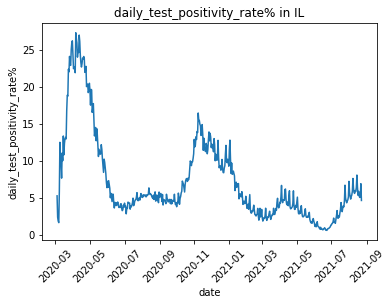

In [5]:
graph('IL','daily_test_positivity_rate%')

However, some data may need to be smoothed out with a seven day rolling average in order to be readable. Using the "rolling=True" command smooths out the variable by calculating its seven day rolling average.

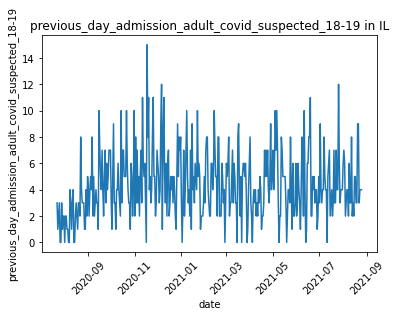

In [ ]:
graph('IL', 'previous_day_admission_adult_covid_suspected_18-19')

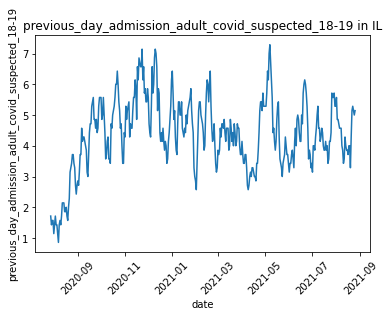

In [ ]:
graph('IL', 'previous_day_admission_adult_covid_suspected_18-19', rolling=True)

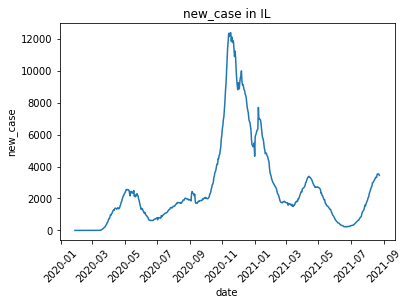

In [ ]:
graph('IL', 'new_case', rolling=True)

A more complex function can chart overlays between two different states' data for the same variable. The inputs are mostly the same as the basic graphing function except two state abbreviations must be used.

In [18]:
def plot_overlay(state1, state2, var, rolling=False):
  plt.figure(figsize = (18, 5))
  fig,ax=plt.subplots()
  plt.grid()
  x_data1 = usa_covid_data.loc[
          usa_covid_data['state']==state1][['date']]
  if rolling==True:
    y_data1 = seven_day_average(usa_covid_data.loc[usa_covid_data['state']==state1][
            [var]])
  else:
    y_data1 = usa_covid_data.loc[usa_covid_data['state']==state1][
            [var]]
  plt.plot(x_data1, 
          y_data1,marker="o", label=f"{state1} {var}")
  x_data2 = usa_covid_data.loc[
          usa_covid_data['state']==state2][[
          'date']]
  if rolling==True:
    y_data2 = seven_day_average(usa_covid_data.loc[
            usa_covid_data['state']==state2][[
            var]])
  else:
    y_data2 = usa_covid_data.loc[
            usa_covid_data['state']==state2][[
            var]]
  plt.plot(x_data2, y_data2, marker="+", color='red')
  plt.title(f"{var} in {state1} vs {state2}")
  plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(round(10)))
  plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
  plt.xlabel('Date')
  plt.ylabel(var)
  plt.legend([state1, state2])
  plt.show()

New York and Kentucky had similar rates of vaccination until May when New York vaccination rates began to outpace Kentucky's. 

<Figure size 1296x360 with 0 Axes>

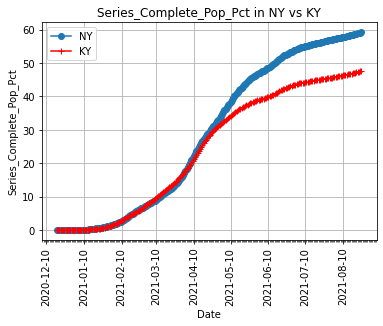

In [19]:
plot_overlay('NY', 'KY', 'Series_Complete_Pop_Pct', rolling=True)

Even more complex logic is needed to overlay two graphs with seperate y axis. Input a state abbreviation followed by the variable you wish to track for that state. Do this again for the second state and variable you'd wish to track. You can use the same state twice. "rolling1" smooths out the first variable and "rolling2" smooths out the second variable.

In [41]:
def two_y_axis(state1, var1, state2, var2, rolling1=False, rolling2=False):
  fig,ax=plt.subplots()
  x_data1 = usa_covid_data.loc[
          (usa_covid_data['state']==state1)&(usa_covid_data[
          var1].notna())&(usa_covid_data[
          var2].notna())][[
          'date']]
  if rolling1==True:
       y_data1 = seven_day_average(usa_covid_data.loc[
          (usa_covid_data['state']==state1)&(usa_covid_data[
          var1].notna())&(usa_covid_data[
          var2].notna())][[
          var1]])
  else:
        y_data1 = usa_covid_data.loc[
          (usa_covid_data['state']==state1)&(usa_covid_data[
          var1].notna())&(usa_covid_data[
          var2].notna())][[
          var1]]
  ax.plot(x_data1, y_data1, label=var1)
  ax.set_xlabel("date")
  ax.set_ylabel(var1)
  plt.title(f'{state1} {var1} vs {state2} {var2}')
  ax.tick_params(axis='x', rotation=90)
  ax2=ax.twinx()
  ax2.set_ylabel(var2)
  if rolling2==True:
    y_data2 = seven_day_average(usa_covid_data.loc[
            (usa_covid_data['state']==state1)&(usa_covid_data[
            var1].notna())&(usa_covid_data[
            var2].notna())][[
            var2]])
  else:
    y_data2 = usa_covid_data.loc[
            (usa_covid_data['state']==state1)&(usa_covid_data[
            var1].notna())&(usa_covid_data[
            var2].notna())][[
            var2]]
  ax2.plot(x_data1, y_data2,color='red', label= var2)
  lines = ax.get_lines() + ax2.get_lines()
  ax.legend(lines, [line.get_label() for line in lines], loc='upper left')
  plt.show()

This plot compares New York's vaccination rate with its daily case numbers.

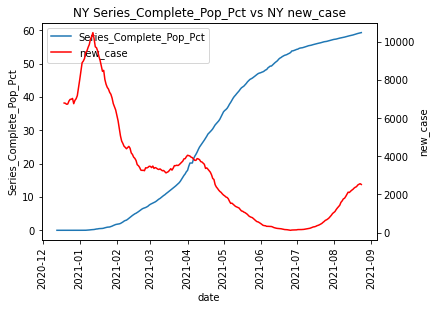

In [23]:
two_y_axis('NY', 'Series_Complete_Pop_Pct', 'NY', 'new_case', rolling2=True)

While this graph compares the movement of daily cases in Illinois with daily deaths. 

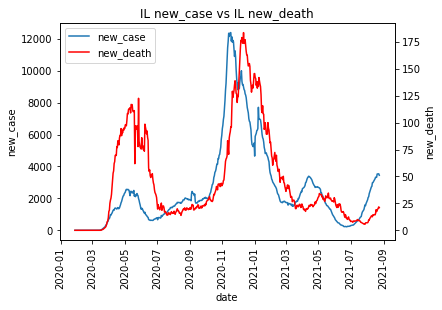

In [24]:
two_y_axis('IL', 'new_case', 'IL', 'new_death', rolling1=True, rolling2=True)